# Generate Data for EKF

In [39]:
from ekf import run_linear_ekf, LinearEkf, State
import numpy as np
import matplotlib.pyplot as plt

In [40]:
dt = 0.1
t_max = 10000
t = np.arange(0, t_max, dt)
n = len(t)

In [41]:
# generate_car_data function
def generate_car_data(t, 
                      pos_noise=3.0,     # meters
                      vel_noise=0.5,     # m/s
                      yaw_noise=0.02):   # rad
    """
    Generate smooth car trajectory + noisy observations for EKF testing.
    t : time array (seconds)
    """
    dt = np.diff(t, prepend=t[0])

    # True state arrays
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    yaw = np.zeros_like(t)
    v = np.zeros_like(t)

    # Initial state
    x[0], y[0] = 0.0, 0.0
    yaw[0] = 0.0
    v[0] = 5.0  # m/s

    

    # Generate trajectory
    for i in range(1, len(t)):
        # Smooth acceleration + steering-like behavior
        a = 0.5*np.sin(0.2*t[i]) + np.random.normal(0, .3)  # randomish accel
        omega = 0.3*np.sin(0.1*t[i]) + np.random.normal(0, 2)   # smooth turning rate

        v[i] = v[i-1] + a * dt[i]
        yaw[i] = yaw[i-1] + omega * dt[i]
        x[i] = x[i-1] + v[i] * np.cos(yaw[i]) * dt[i]
        y[i] = y[i-1] + v[i] * np.sin(yaw[i]) * dt[i]

    # True states grouped
    true_state = np.vstack([x, y, yaw, v])

    # Noisy observations (modify as needed)
    z_pos = true_state[:2,:] + np.random.normal(0, pos_noise, (2, len(t)))
    z_vel = true_state[3,:] + np.random.normal(0, vel_noise, len(t))
    z_yaw = true_state[2,:] + np.random.normal(0, yaw_noise, len(t))

    obs = {
        "pos": z_pos,
        "vel": z_vel,
        "yaw": z_yaw
    }

    return true_state, obs

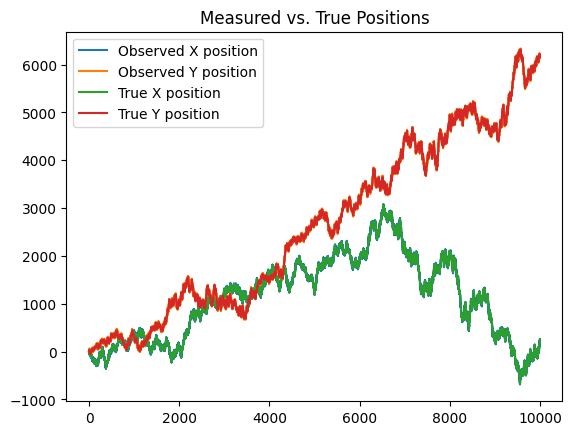

In [42]:
# Generate and plot car data 
x_true, obs = generate_car_data(t, pos_noise=10)


plt.title("Measured vs. True Positions")
plt.plot(t, obs["pos"][:2,:].T, label=("Observed X position","Observed Y position"))
plt.plot(t, x_true[:2,:].T, label=("True X position","True Y position"))
plt.legend()


# Linear Kalman Filter

In [43]:
# Linear KF Initialization

# Simple 4d state (x, y, vx, vy)
# Measurement is (x, y)

# State
x0 = np.array([0,0,0,0])
P0 = np.diag(np.array([250, 250, 5, 5]))

# Model
F = np.array([
    [0,0,1,0],
    [0,0,0,1],
    [0,0,0,0],
    [0,0,0,0]
])
B = np.array([
    [0,0],
    [0,0],
    [1,0],
    [0,1]
]) # No input but still need something
H = np.array([
    [1,0,0,0],
    [0,1,0,0]
])

# Noise
Q = 10 * np.eye(4) # NOT CORRECTING FOR INPUT BECAUSE WE CANNOT MODEL NONLINEAR
R = 14 * np.eye(2) # Since 2 measurements

linear_ekf = LinearEkf(F, B, H, Q, R)
state = State(x0, P0)


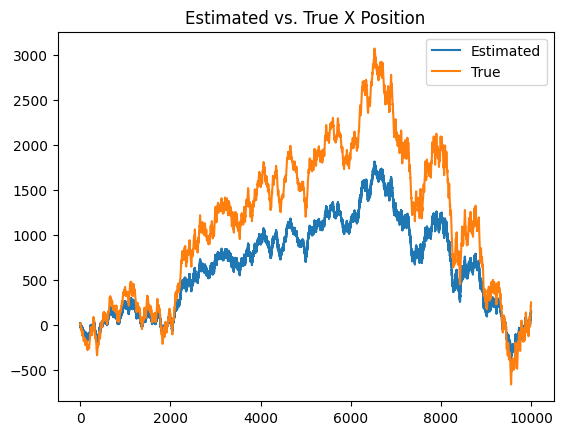

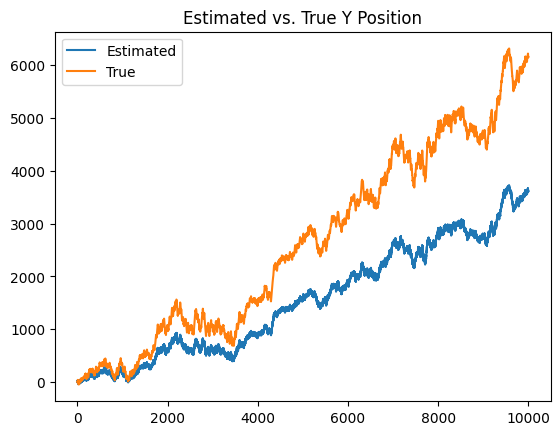

In [44]:
x_arr = np.zeros((4,n))
err = np.zeros((2,n))

for i in range(n):
    
    # P_arr[i,:] = state.P
    z = obs["pos"][:,i]

    state = run_linear_ekf(state, linear_ekf, None, z)
    x_arr[:,i] = state.x

start = 1


plt.title("Estimated vs. True X Position")
plt.plot(t[start:], x_arr[0,start:])
plt.plot(t[start:], x_true[0,start:])
plt.legend(["Estimated","True"])
plt.show()


plt.title("Estimated vs. True Y Position")
plt.plot(t[start:], x_arr[1,start:])
plt.plot(t[start:], x_true[1,start:])
plt.legend(["Estimated","True"])
plt.show()

# Extended Kalman Filter - Good model

In [45]:
from ekf import run_nonlinear_ekf, NonlinearEkf

In [60]:
# EKF Initialization

# Simple 4d state (x, y, yaw, v)
# Measurement is (x, y, v)

# State
x0 = np.array([0,0,0,0])
P0 = np.diag(np.array([250, 250, 2, 5]))

def transition_model(state: np.ndarray, u: np.ndarray):  
    x, y, yaw, v = state
    a, omega = u

    return np.array([
        x + v*np.cos(yaw)*dt,
        y + v*np.sin(yaw)*dt,
        yaw + omega*dt,
        v + a*dt
    ])

def get_F(state: np.ndarray):
    _, _, yaw, v = state
    return np.array([
          [1, 0, -v*np.sin(yaw)*dt, np.cos(yaw)*dt],
          [0, 1, v*np.cos(yaw)*dt, np.sin(yaw)*dt],
          [0, 0, 1, 0],
          [0, 0, 0, 1]
    ])

def measurement_model(state: np.ndarray):
    x, y, _, _ = state
    return np.array([x,y]).T

def get_H(_: np.ndarray):
    return np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])


# Noise
Q = np.diag([10, 10, 1, 1]) # NOT CORRECTING FOR INPUT BECAUSE WE CANNOT MODEL NONLINEAR
R = 15 * np.eye(2) # Since 2 measurements

nonlinear_ekf = NonlinearEkf(transition_model, get_F, measurement_model, get_H, Q, R)
state = State(x0, P0)


In [62]:
x_arr = np.zeros((4,n))
err = np.zeros((2,n))

for i in range(n):
    
    # P_arr[i,:] = state.P
    z = obs["pos"][:,i]
    a = 0.5*np.sin(0.2*t[i])  # randomish accel
    omega = 0.3*np.sin(0.1*t[i])   # smooth turning rate
    u = np.array([a,omega])


    state = run_nonlinear_ekf(state, nonlinear_ekf, u, z)
    x_arr[:,i] = state.x

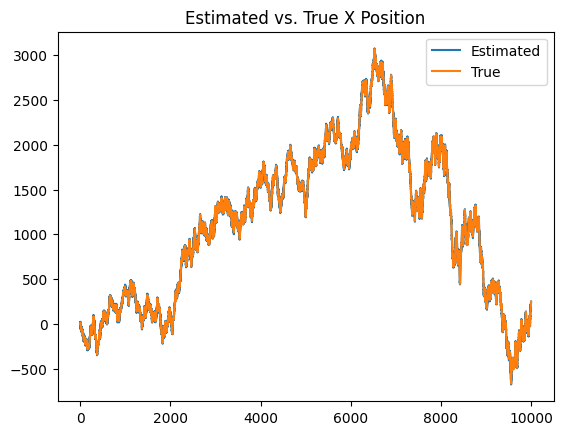

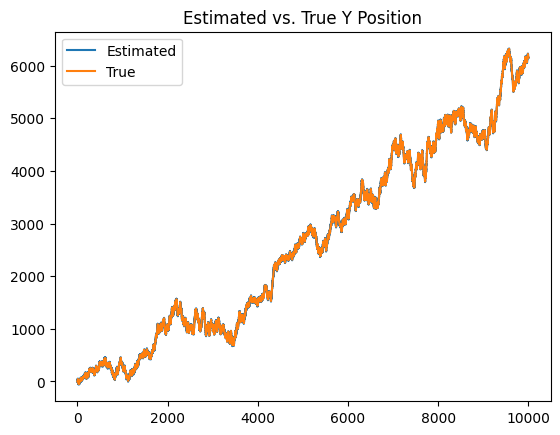

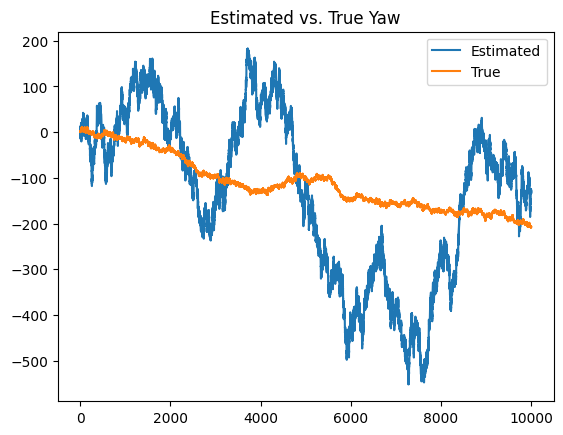

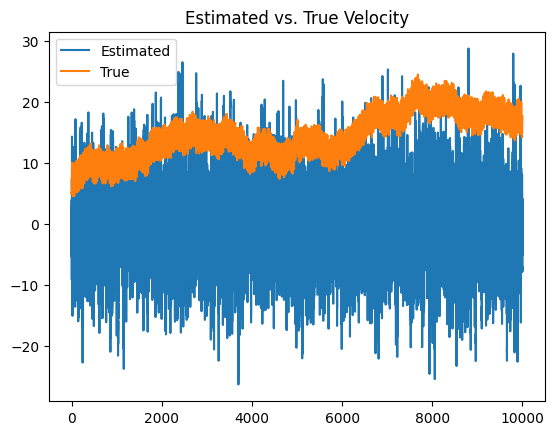

In [64]:
start = 0

plt.title("Estimated vs. True X Position")
plt.plot(t[start:], x_arr[0,start:])
plt.plot(t[start:], x_true[0,start:])
plt.legend(["Estimated","True"])
plt.show()


plt.title("Estimated vs. True Y Position")
plt.plot(t[start:], x_arr[1,start:])
plt.plot(t[start:], x_true[1,start:])
plt.legend(["Estimated","True"])
plt.show()

# UHHH 
plt.title("Estimated vs. True Yaw")
plt.plot(t, x_arr[2])
plt.plot(t, x_true[2])
plt.legend(["Estimated","True"])
plt.show()

# UHHH 
plt.title("Estimated vs. True Velocity")
plt.plot(t, x_arr[3])
plt.plot(t, x_true[3])
plt.legend(["Estimated","True"])
plt.show()

# Extended Kalman Filter - Bad Model

In [65]:
# EKF Initialization

# Simple 4d state (x, y, yaw, v)
# Measurement is (x, y)

def transition_model(state: np.ndarray, u: np.ndarray):  
    x, y, yaw, v = state
    a, omega = u

    return np.array([
        x + 2*v*np.cos(yaw)*dt*dt,
        y + v*np.sin(yaw),
        yaw*0.9 + omega*dt,
        0.9*v + a*dt
    ])


# THIS IS MISSING SOME dt in 2 of the measurements
def get_F(state: np.ndarray):
    _, _, yaw, v = state
    return np.array([
          [1, 0, -2*v*np.sin(yaw)*dt*dt, 2*np.cos(yaw)*dt*dt],
          [0, .2, v*np.cos(yaw)*dt, np.sin(yaw)*dt],
          [0, 0, 0.9, 0],
          [0, 0, 0, 0.9]
    ])

def measurement_model(state: np.ndarray):
    x, y, _, _ = state
    return np.array([x,y]).T

def get_H(_: np.ndarray):
    return np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])


# Noise
Q = np.diag([10, 10, 0.1, 1]) # NOT CORRECTING FOR INPUT BECAUSE WE CANNOT MODEL NONLINEAR
R = 7 * np.eye(2) # Since 2 measurements

nonlinear_ekf = NonlinearEkf(transition_model, get_F, measurement_model, get_H, Q, R)
state = State(x0, P0)


In [66]:
x_arr = np.zeros((4,n))
err = np.zeros((2,n))

for i in range(n):
    
    # P_arr[i,:] = state.P
    z = obs["pos"][:,i]

    omega = 0.5*np.sin(0.1*t[i])  # randomish accel
    a = 0.3*np.cos(0.1*t[i])   # smooth turning rate
    u = np.array([a,omega])


    state = run_nonlinear_ekf(state, nonlinear_ekf, u, z)
    x_arr[:,i] = state.x

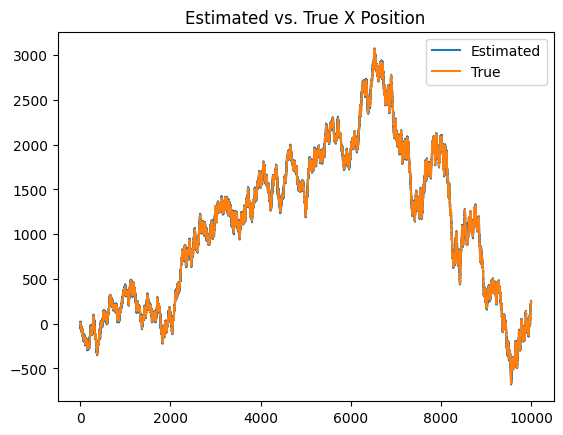

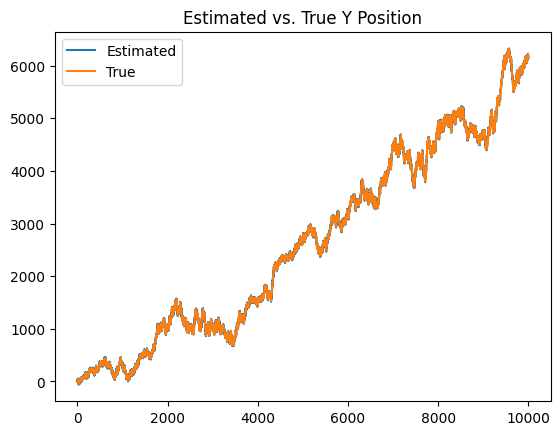

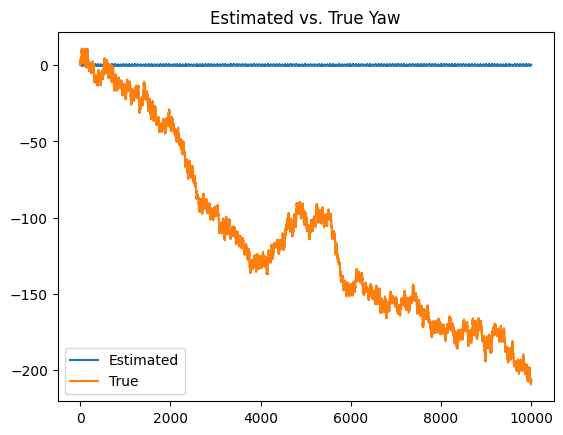

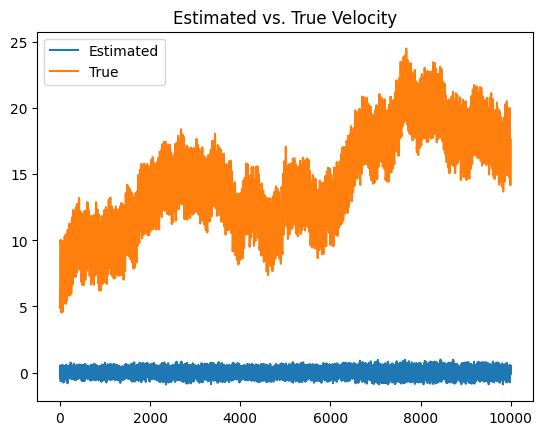

In [ ]:
start = 0
end = -100

plt.title("Estimated vs. True X Position")
plt.plot(t[start:], x_arr[0,start:])
plt.plot(t[start:], x_true[0,start:])
plt.legend(["Estimated","True"])
plt.show()


plt.title("Estimated vs. True Y Position")
plt.plot(t[start:], x_arr[1,start:])
plt.plot(t[start:], x_true[1,start:])
plt.legend(["Estimated","True"])
plt.show()

# UHHH 
plt.title("Estimated vs. True Yaw")
plt.plot(t, x_arr[2])
plt.plot(t, x_true[2])
plt.legend(["Estimated","True"])
plt.show()

# UHHH 
plt.title("Estimated vs. True Velocity")
plt.plot(t, x_arr[3])
plt.plot(t, x_true[3])
plt.legend(["Estimated","True"])
plt.show()

